In [1]:
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
figsize(11, 9)

## Problem
On an unknown day in a 70 days period, a user's phone plan changes. We would like to work out the most likely days for this change, and how the change may have effected their texting behvaiour. We have been provided data of daily texting rated in a file `txt_data.txt`

Exaple taken and modified from [Bayesian Methods for Hackers chapter 1](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC3.ipynb)

In [2]:
np.loadtxt("txt_data.txt")

array([13., 24.,  8., 24.,  7., 35., 14., 11., 15., 11., 22., 22., 11.,
       57., 11., 19., 29.,  6., 19., 12., 22., 12., 18., 72., 32.,  9.,
        7., 13., 19., 23., 27., 20.,  6., 17., 13., 10., 14.,  6., 16.,
       15.,  7.,  2., 15., 15., 19., 70., 49.,  7., 53., 22., 21., 31.,
       19., 11., 18., 20., 12., 35., 17., 23., 17.,  4.,  2., 31., 30.,
       13., 27.,  0., 39., 37.,  5., 14., 13., 22.])

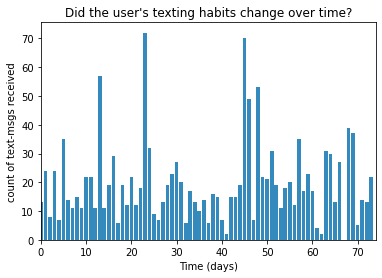

In [3]:
figsize(12.5, 5.5)
count_data = np.loadtxt("txt_data.txt")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data);

Two texting regeimes: $C_1$ and $C_2$
$$ C_i \sim \text{Poisson}(\lambda)  $$

$$
\lambda = 
\begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$

\begin{align}
&\lambda_1 \sim \text{Exp}( \alpha ) \\\
&\lambda_2 \sim \text{Exp}( \alpha )
\end{align}

Why the same alpha for both is we think lambda differs- because these are the priors- the bayesian step will influence them.

\begin{align}
& \tau \sim \text{DiscreteUniform(1,70) }\\\\
& \Rightarrow P( \tau = k ) = \frac{1}{70}
\end{align}

<img src="http://i.imgur.com/7J30oCG.png"/>

In [4]:
import pymc as pm

with pm.Model() as model:
    alpha = 1.0/count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)
    
with model:
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)
    
with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data)

In [5]:
### MCMC
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000, step=step, return_inferencedata=False)
    
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [lambda_1]
>Metropolis: [lambda_2]
>Metropolis: [tau]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 35 seconds.


## Analysis

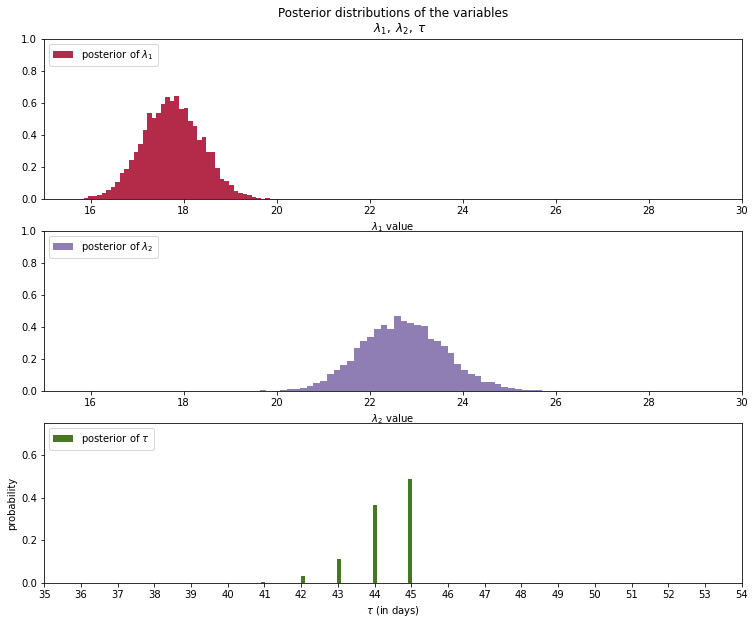

In [6]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=50, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=50, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

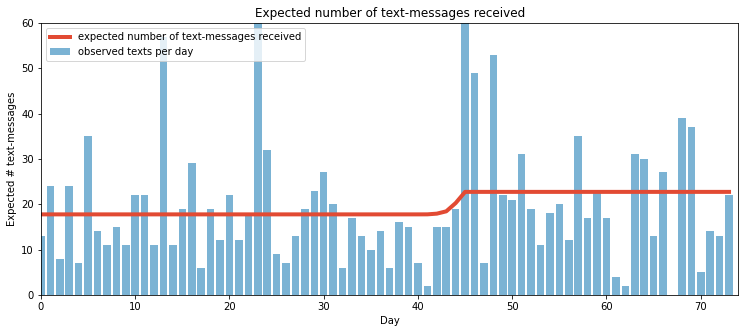

In [7]:
figsize(12.5, 5)


N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    ix = day < tau_samples
    
    expected_texts_per_day[day] = (  lambda_1_samples[ix].sum()  / N
                                   + lambda_2_samples[~ix].sum() / N)


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");

## Diagnostic plots with PyMC directly

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>]], dtype=object)

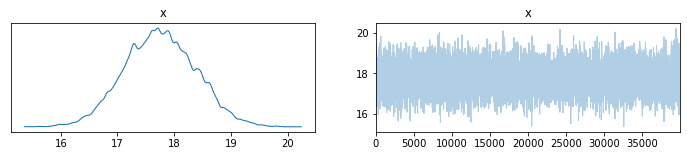

In [8]:
pm.plot_trace(lambda_1_samples)

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>]], dtype=object)

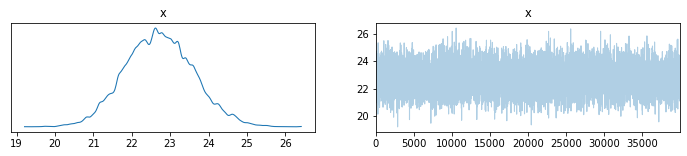

In [9]:
pm.plot_trace(lambda_2_samples)

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>]], dtype=object)

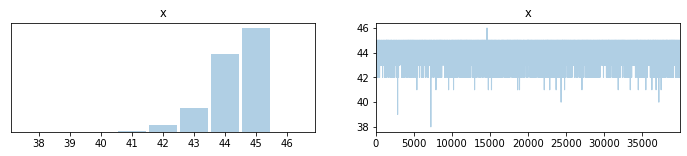

In [10]:
pm.plot_trace(tau_samples)

<AxesSubplot:title={'center':'x\n0'}>

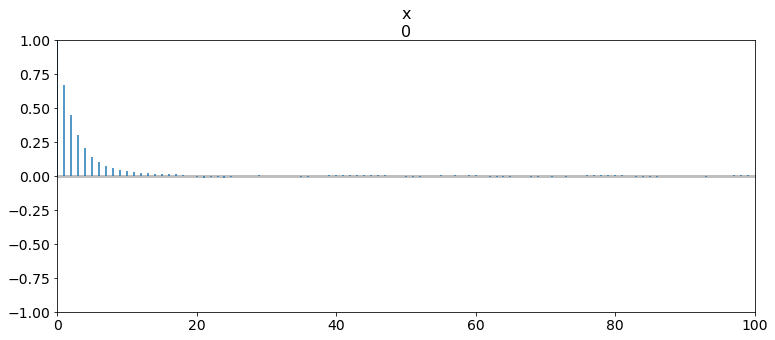

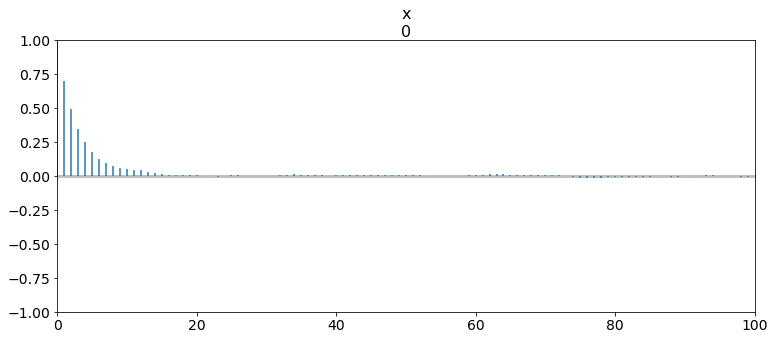

In [11]:
pm.plot_autocorr(lambda_1_samples)
pm.plot_autocorr(lambda_2_samples)

## Bad data  - no tuning, sample too small

In [12]:
with model:
    step = pm.Metropolis()
    bad_trace = pm.sample(400, tune=1, step=step, return_inferencedata=False)
    
bad_lambda_1_samples = bad_trace['lambda_1']

Only 400 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [lambda_1]
>Metropolis: [lambda_2]
>Metropolis: [tau]


Sampling 4 chains for 1 tune and 400 draw iterations (4 + 1_600 draws total) took 17 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


<AxesSubplot:title={'center':'x\n0'}>

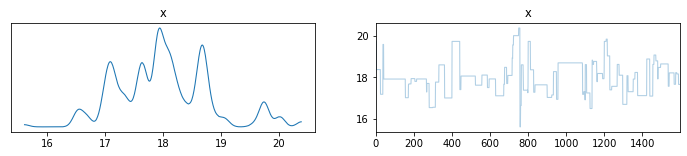

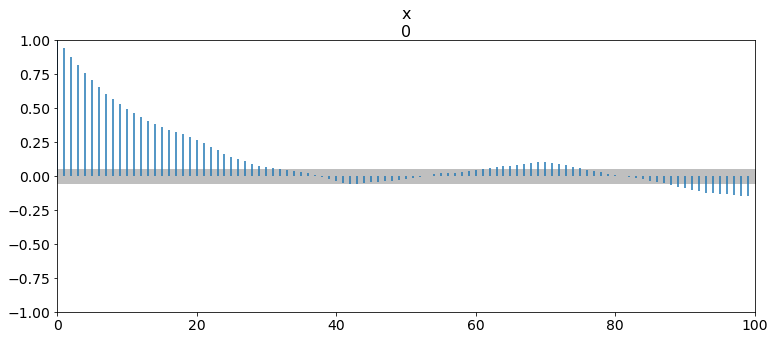

In [13]:
pm.plot_trace(bad_lambda_1_samples)
pm.plot_autocorr(bad_lambda_1_samples)